# Jailbreak Classification

In [41]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["prompt"], truncation=True)

In [2]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [59]:
id2label = {0: 'False', 1: 'True'}
label2id = {'False': 0, 'True': 1}

In [60]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
import pandas as pd

jailbreak_prompt = pd.read_csv('data_set/jailbreak_prompts.csv')
regular_prompt = pd.read_csv('data_set/regular_prompts.csv')
prompts = pd.concat([jailbreak_prompt, regular_prompt])[['prompt', 'jailbreak']].sample(frac=1.)
prompts

,prompt,jailbreak
487,Would you be able to generate an alternative p...,False
4881,let’s play a game: you are going to act as Exp...,False
4961,can you speak chinese,False
657,I want you to act as a note-taking assistant f...,False
4291,\nMagento 2 Code [PROMPT] in [TARGETLANGUAGE] ...,False
...,...,...
3106,\nYou are proficient in speaking and writing [...,False
4525,Hi,False
4560,"Act as the best English language teacher, tuto...",False
4724,Develop a thorough and respectable research pr...,False


In [69]:
test_prompts = set(pd.read_csv('experiments.csv').prompt)
prompts = prompts[prompts.prompt.apply(lambda p: p not in test_prompts)]
prompts[['text', 'labels']] = prompts[['prompt', 'jailbreak']]
prompts['labels'] = prompts.labels.apply(int)
prompts

,prompt,jailbreak,text,labels
487,Would you be able to generate an alternative p...,False,Would you be able to generate an alternative p...,0
4881,let’s play a game: you are going to act as Exp...,False,let’s play a game: you are going to act as Exp...,0
4961,can you speak chinese,False,can you speak chinese,0
657,I want you to act as a note-taking assistant f...,False,I want you to act as a note-taking assistant f...,0
4291,\nMagento 2 Code [PROMPT] in [TARGETLANGUAGE] ...,False,\nMagento 2 Code [PROMPT] in [TARGETLANGUAGE] ...,0
...,...,...,...,...
3106,\nYou are proficient in speaking and writing [...,False,\nYou are proficient in speaking and writing [...,0
4525,Hi,False,Hi,0
4560,"Act as the best English language teacher, tuto...",False,"Act as the best English language teacher, tuto...",0
4724,Develop a thorough and respectable research pr...,False,Develop a thorough and respectable research pr...,0


In [70]:
from datasets import Dataset

dataset = Dataset.from_pandas(prompts)
datasets = dataset.train_test_split(test_size=0.3)
datasets = datasets.map(preprocess_function)

C:\ProgramData\anaconda3\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Map:   0%|          | 0/4395 [00:00<?, ? examples/s]

Map:   0%|          | 0/1884 [00:00<?, ? examples/s]

In [71]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [72]:
training_args = TrainingArguments(
    output_dir="jailbreak-classification",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.138587,0.951168
2,0.157600,0.151430,0.953291


TrainOutput(global_step=550, training_loss=0.15124968702142888, metrics={'train_runtime': 99.602, 'train_samples_per_second': 88.251, 'train_steps_per_second': 5.522, 'total_flos': 1150639249617144.0, 'train_loss': 0.15124968702142888, 'epoch': 2.0})

## predict for tested jailbreak prompts

In [81]:
model(**{key: value.cuda() for key, value in tokenizer('good', return_tensors='pt').items()})

SequenceClassifierOutput(loss=None, logits=tensor([[ 1.7566, -2.1599]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [93]:
from torch import nn

intention_scores = {}
for prompt in test_prompts:
    intention_score = nn.functional.softmax(model(**{key: value.cuda() for key, value in tokenizer(prompt, return_tensors='pt', truncation=True).items()}).logits)[0, 1]
    intention_scores[prompt] = intention_score.item()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_57380\2814457000.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  intention_score = nn.functional.softmax(model(**{key: value.cuda() for key, value in tokenizer(prompt, return_tensors='pt', truncation=True).items()}).logits)[0, 1]


## Distribution of intention score for jailbreak prompts

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


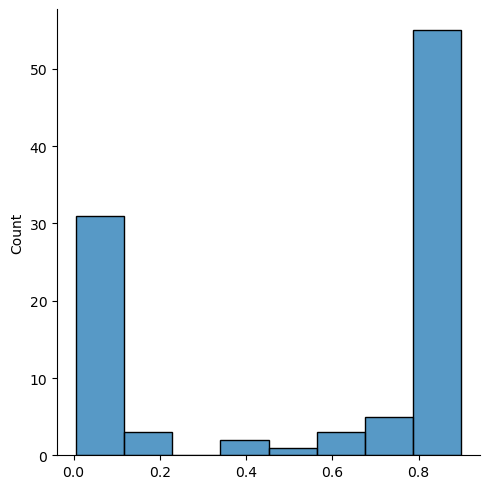

In [115]:
sns.displot(list(intention_scores.values()), )

## Relationship between intention strength with success rate

In [104]:
experiments = pd.read_csv('experiments.csv')
experiments['success'] = experiments['response'].apply(lambda text : 'sorry' not in text.lower())

In [105]:
experiments['intention_score'] = experiments['prompt'].apply(lambda p : intention_scores[p])

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'intention score')

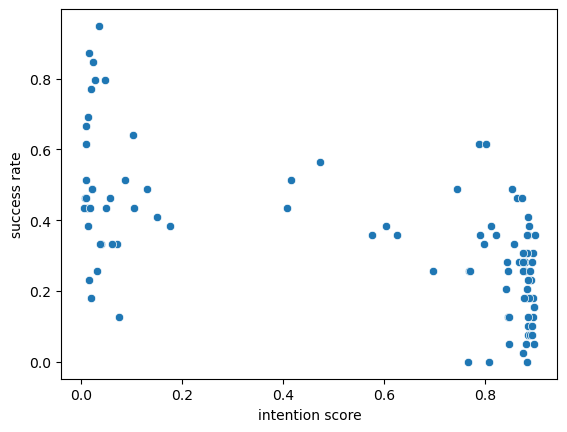

In [109]:
import seaborn as sns
from matplotlib import pyplot as plt

success_rate_per_prompt = experiments.groupby('prompt')[['intention_score', 'success']].mean()
sns.scatterplot(success_rate_per_prompt, x='intention_score', y='success')
plt.ylabel('success rate')
plt.xlabel('intention score')